In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import re
import cftime
from datetime import datetime
from dask.diagnostics import ProgressBar
from scipy.stats import t
from scipy.stats import linregress
from eofs.xarray import Eof
from eofs.examples import example_data_path
import calendar

In [59]:
class EnsembleMemberCalculations:
    def __init__(self, data_path: Path, model=None):
        #use self. to access attributes
        self.data_path = Path(data_path)
        
        #referencing the parent model and setting up shortcuts
        self.model = model
        self.experiment = model.experiment if model else None
        self.all_experiments = self.experiment.all_experiments if self.experiment else None


        #extracting the member_id (ensemble number) from the filename as named in CMIP6 convention
        match = re.search(r"(r\d+i\d+p\d+f\d+)", self.data_path.stem)
        if not match:
            raise ValueError(f"Could not extract the member_id from filenmae: {self.data_path.name}")

        #selecting the ensemble number and assigning it to the member ID
        self.member_id = match.group(1)


        self.data = None

    def load_data(self):
        #loads the data of an ensemble member
        self.data = xr.open_dataset(self.data_path)
        return self.data

    def get_calendar_type(self):
        if self.model is None:
            raise RuntimeError("Model is not set")
        return self.model.calendar_type

    def get_time_bounds(self):
        """
        Access the model's time_bounds - each model has a different calendar thus type of time to index/slice by
        """
        if self.model is None or self.model.time_bounds is None:
            raise RuntimeError("Model or time_bounds is not set")
        return self.model.time_bounds

    def select_data(self, varname: str):
        """
        Just selecting some data from the time bounds in model
        """
        ds = self.load_data()
        start, end, delta = self.model.time_bounds
        ds = ds[varname].sel(time=slice(start, end))
        
        return ds

    def crop_to_domain_ensemble(self, da: xr.DataArray):
        """
        Crops the ensemble members data (anomaly, raw data etc.) to the lat and lon of the domain
        lat_bounds = (lat_min, lat_max)
        lon_bounds = (lon_min, lon_max)
        Assuming data of the format -180 to 180, -90 to 90???
        Will add another function to check and if not flag error
        Will be a bit for if model is era5 shift the coords at somepoint in the processing data stages.
        Need to already have selected the variable"""

        if self.all_experiments and self.all_experiments.lat_bounds and self.all_experiments.lon_bounds:
            da = da.sel(
                lat=slice(self.all_experiments.lat_bounds[0], self.all_experiments.lat_bounds[1]),
                lon = slice(self.all_experiments.lon_bounds[0], self.all_experiments.lon_bounds[1])
            )
        return da

    def calc_anomaly(self, output_file: Path, varname: str):
        """
        Will calculate the anomaly
        """
        #print(output_file)
        #print(self.model.name)
        if output_file.exists():
            #print(f"Loading the exisiting file for the anomaly from: {output_file}")
            anomaly = xr.open_dataset(output_file)[varname]
            anomaly_cropped = self.crop_to_domain_ensemble(anomaly)
            return anomaly_cropped

   # def cal_seasonal_mean(self)

        

class ModelCalculations:
    def __init__(self, folder: Path, experiment):
        self.folder = Path(folder)
        self.experiment = experiment
        self.all_experiments = self.experiment.all_experiments if self.experiment else None

        #can now set the model name using the folder name
        #the .name takes the last bit of the filepath (which in this case is the model)
        self.name = self.folder.name
        
        #creating my dictionary of ensemble members
        self.members = {}
        for i, file in enumerate(self.folder.glob("*.nc")):
            if i >= 3:
                break
            member = EnsembleMemberCalculations(file, model=self)
            self.members[member.member_id] = member
        
        #basically I pick the first member (load in just one)
        #doing this to then use to find the calendar type
        #and then find the time bounds as this will be the same time (correct datetime) per model
        member1 = next(iter(self.members.values()))
        member1.load_data()

        #find the calendar type
        time_var = member1.data["time"]
        self.calendar_type = type(time_var.time.values[0])
        self.time_bounds = None

    def set_time_bounds(self, start_year: int, end_year: int):
        #selecting the correct datetime format for the chosen time period
        if issubclass(self.calendar_type, cftime.DatetimeNoLeap):
            start = cftime.DatetimeNoLeap(start_year,1,16)
            end = cftime.DatetimeNoLeap(end_year,12,16)
        elif issubclass(self.calendar_type, cftime.Datetime360Day):
            start = cftime.Datetime360Day(start_year,1,16)
            end = cftime.Datetime360Day(end_year,12,16)
        else:
            start = datetime(start_year,1,16)
            end = datetime(end_year,12,16)

        #assumes that the last year is filled with data
        delta = end.year - start.year + 1

        self.time_bounds = (start, end, delta)
        return self.time_bounds

    def crop_to_domain_model(self, da: xr.DataArray):
        """
        Crops the ensemble members data (anomaly, raw data etc.) to the lat and lon of the domain
        lat_bounds = (lat_min, lat_max)
        lon_bounds = (lon_min, lon_max)
        Assuming data of the format -180 to 180, -90 to 90???
        Will add another function to check and if not flag error
        Will be a bit for if model is era5 shift the coords at somepoint in the processing data stages.
        Need to already have selected the variable"""

        if self.all_experiments and self.all_experiments.lat_bounds and self.all_experiments.lon_bounds:
            da = da.sel(
                lat=slice(self.all_experiments.lat_bounds[0], self.all_experiments.lat_bounds[1]),
                lon = slice(self.all_experiments.lon_bounds[0], self.all_experiments.lon_bounds[1])
            )
        return da


    def calc_ensemble_mean(self, varname: str):
        """
        Calculate the SPATIAL ensemble mean for a variable
        Restrict it to the time bounds
        Could in future restrict to an area
        If the file exists load this instead
        """
        output_file = self.all_experiments.output_dir / f"ens_mean_spat/{model_name}/{varname}_mon_{self.name}_{model_name}_spatial_DJF_EM_1850-2015.nc"
        
        if output_file.exists():
            print(f"Loading the exisiting file for the spatial ensemble mean from: {output_file}")
            ens_mean = xr.open_dataset(output_file)[varname]
            return ens_mean
        
        #Get all the filepaths from the ensemble members
        #this line basically is getting the filepaths of the ensemble member class objects - i think?
        file_paths = [member.data_path for member in self.members.values()]

        #then opening them all together
        ds = xr.open_mfdataset(
            file_paths,
            combine="nested",
            concat_dim="member",
            parallel=True,
            chunks={"member": 1}
        )[varname]

        #selecting the time period
        start,end, delta = self.time_bounds
        ds = ds.sel(time=slice(start,end))

        #calculating the ensemble mean across the members
        ens_mean = ds.mean(dim="member")
    
        # Compute the result with a progress bar
        print(f"Computing the ensemble mean for {self.name}...")
        with ProgressBar():
            ens_mean.compute()#.to_netcdf(output_file)

        ens_mean.to_netcdf(output_file)
        print(f'Ensemble mean NOT saved to {output_file}')

        return ens_mean

    def calc_seasonal_mean_per_model(self, varname:str):
        """
        Calculating the seasonal ensemble mean (could actually just be the seasonal mean for ay single file!!!)
        Only accpeting one file so per model
        Will save the seasonal mean as well as outputting it
        Wil crop to the already saved time periods.
        Will at some point make more versatille to choose the months of the year etc. as a list of int.
        """

        #select the time bounds and seasons
        start,end = self.time_bounds
        print(start,end)
        months = self.all_experiments.season
        season = "".join([calendar.month_abbr[m][0] for m in months])
        print(months, season)
        
        seas_EM_output_file = self.all_experiments.output_dir / f"ens_mean_spat/{self.experiment.name}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_spatial_{season}_EM_1850-2015.nc"
        
        if seas_EM_output_file.exists():
            print(f"Loading the seasonal mean for model: {self.name}")
            seasonal_mean = xr.open_dataset(seas_EM_output_file)[varname]
            return seasonal_mean

        #loading the ensemble mean
        ens_mean = self.calc_ensemble_mean(varname)

        #checking it is a datetime object - already done???
        #ens_mean['time'] = xr.decode(ens_mean).time

        #selecting the ensemble mean for the specified time (might load full ensemble mean as this is already calculated and then slice here)
        ens_mean = ens_mean.sel(time=slice(start,end))

        #creating mask for the season and grouping the months
        mask = ens_mean['time'].dt.month.isin(months)
        months_in_seas = ens_mean.sel(time=mask)

        #assigning a 'season year'
        season_year = months_in_seas['time'].dt.year

        #general code for if season WRAPS then fix the year to avg over
        if months[0] > months[-1]:
            season_year = xr.where(months_in_seas['time'].dt.month >= months[0],
                                  season_year +1,
                                  season_year)

        #assign as "year" instead of "season_year" for future bits
        months_in_seas = months_in_seas.assign_coords(year=season_year)
        
        #now groupby and average over the years
        ens_mean_seas = months_in_seas.groupby('year').mean(dim='time')
        #ens_mean_seas.to_netcdf(seas_EM_output_file)

        print('calc seas_mean')
        
        return ens_mean_seas

    def calc_linear_trend_per_model(self, varname:str):
        """
        Calcualte the linear trend from the seasonal ensemble mean
        Full stats file
        Converts from per unit time to just the change over the entire period (delta)"""
        #getting the timebounds
        start,end, delta = self.time_bounds
             
        #create and check if output_file exists
        output_file = self.all_experiments.output_dir / f"trend_calc_LESFMIP/linear_regression/NAO/{self.experiment.name}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_DJF_linear_trend_1850-2015_stats.nc"

        if output_file.exists():
            print(f"loading the linear trend for model: {self.name}")
            return xr.open_dataset(output_file)
            
        #call the seasonal ensemble mean method
        seas_ens_mean = self.calc_seasonal_mean_per_model(varname)
        print(seas_ens_mean)
    
        time = seas_ens_mean['year'].values
        lat = seas_ens_mean['lat'].values
        lon = seas_ens_mean['lon'].values
        time_numeric = np.arange(len(time))
    
        slope = np.full((len(lat), len(lon)), np.nan)
        intercept = np.full((len(lat), len(lon)), np.nan)
        p_value = np.full((len(lat), len(lon)), np.nan)
        stderr = np.full((len(lat), len(lon)), np.nan)

        #now solving for the slope and other stats (multiplying through by delta to convert from per index
        #(year) to change over the entire period)
        for i in range(len(lat)):
            for j in range(len(lon)):
                ts = seas_ens_mean[:, i, j].values
                if np.all(np.isfinite(ts)):
                    reg = linregress(time_numeric, ts)
                    slope[i, j] = reg.slope * delta
                    intercept[i, j] = reg.intercept
                    p_value[i, j] = reg.pvalue
                    stderr[i, j] = reg.stderr * delta
    
        n = len(time_numeric)
        df = n - 2
        alpha = 0.05
        t_crit = t.ppf(1 - alpha/2, df)
    
        ci_lower = slope - t_crit * stderr
        ci_upper = slope + t_crit * stderr
    
        slope_da = xr.DataArray(slope, coords=[lat, lon], dims=["lat", "lon"], name="slope")
        intercept_da = xr.DataArray(intercept, coords=[lat, lon], dims=["lat", "lon"], name="intercept")
        p_value_da = xr.DataArray(p_value, coords=[lat, lon], dims=["lat", "lon"], name="p_value")
        ci_lower_da = xr.DataArray(ci_lower, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_lower")
        ci_upper_da = xr.DataArray(ci_upper, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_upper")
    
        # Save to one combined netCDF file
        trend_stats = xr.Dataset({
            "slope": slope_da,
            "intercept": intercept_da,
            "p_value": p_value_da,
            "slope_CI_lower": ci_lower_da,
            "slope_CI_upper": ci_upper_da
        })
        
        #combined_ds.to_netcdf(output_file)
        return trend_stats

    def calc_anomalies_all_members(self, varname: str,):
        """
        This will calculate the anomaly across the ensemble members
        Could maybe do this for all the other individual ensemble calcs needed to calc anomaly?
        Will return a dictionary {member_id: anomaly_dataarray}
        Only calculates for the hisotircal??? - no need it for all!"""

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for member_id, member in self.members.items():
            output_file = self.all_experiments.output_dir / f"psl_anomalies/{self.experiment.name}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_{member_id}_DJF_anomaly.nc"
            anomaly = member.calc_anomaly(output_file, varname)
            results[member_id] = anomaly
        return results

    def calc_EOF_concat(self, varname: str, max_modes: int):
        """
        Calculates the EOF from a concatenated list of anomalies for one model
        outputs the number of modes specified
        Calls on the anomalies calculated for each ensemble member
        This right now does all models not just historical - need an option for that somewhere???
        """
        output_file = self.all_experiments.output_dir / f"{self.experiment.name}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_DJF_EOF_concat_1850-2015.nc"

        if output_file.exists():
            print(f"Loading the exisiting file for the EOF for: {output_file}")
            EOF = xr.open_dataset(output_file)[varname]
            return EOF


        else:
            print('concatenating')
            #preprocess anomalies method called
            anomalies = self.calc_anomalies_all_members(varname)

            anomaly_list = list(anomalies.values())
            anomaly_concat = xr.concat(anomaly_list, dim="ensemble")
            anomaly_2d = anomaly_concat.stack(time=('ensemble', 'year')).reset_index('time', drop=True)
            anomaly_trans = anomaly_2d.transpose('time', 'lat', 'lon')
            
            coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
            wgts = np.sqrt(coslat)[...,np.newaxis]

            solver = Eof(anomaly_trans, weights=wgts)
            EOF = solver.eofs(neofs=max_modes).sel(mode=([0,max_modes-1]))

            #checking orthogonality
            #1. Get the first two PCs (time series of each mode)
            pcs = solver.pcs(npcs=2, pcscaling=0)  # shape (time, mode)
    
            # 2. Compute their correlation / covariance
            pc_corr = np.corrcoef(pcs[:, 0], pcs[:, 1])[0, 1]
            print("Correlation between PC1 and PC2:", pc_corr)

            # 3. (Optional) Gram matrix of PCs
            G = np.dot(pcs.T, pcs)  # shape (2,2)
            print("Gram matrix of PCs:\n", G)

            #Check orthogonality
            EOF1 = EOF.sel(mode=0)
            EOF2 = EOF.sel(mode=1)
    
            inner = (EOF1 * EOF2).sum(dim=("lat", "lon"))
            norm1 = np.sqrt((EOF1**2).sum(dim=("lat", "lon")))
            norm2 = np.sqrt((EOF2**2).sum(dim=("lat", "lon")))
            cos_sim = inner / (norm1 * norm2)
            is_ortho = bool(np.isclose(inner, 0, atol=1e-10))
            
            print(f"Inner product: {inner:.3e}, Cosine similarity: {cos_sim:.3e}")
            if not is_ortho:
                print("⚠️ Warning: EOF1 and EOF2 are not orthogonal within tolerance!")

        
            #EOF.to_netcdf(output_file)

        return EOF

    def projection(self, varname: str, max_modes):
        #need to somehow specify that its historical EOF ONLY - but maybe still calculate for the other ones - need all anomalies???

        output_file = self.all_experiments.output_dir / f"regression_patterns/NAO/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_EOF_pattern_1850-2015.nc"

        if output_file.exists():
            print("loading EOF file for model:", self.name)
            return xr.open_dataset(output_file)

        trend = self.calc_linear_trend_per_model['slope']
        EOF = self.calc_EOF_concat['eofs']

        #weighting the trend ONLY (EOF already weighted)
        w = np.sqrt(np.cos(np.radians(trend['lat'])))
        w2d, _ = xr.broadcast(w, trend)

        #stacking the trend and EOF 
        trend_w = (trend * w2d).stack(spatial=('lat','lon')).values
        EOF = (EOF).stack(spatial=('lat','lon')).values #lat,lon,mode

        #transpose for the lstsq
        E_matrix = EOF.T

        #solve the weighted least squares
        c = np.linalg.lstsq(E_matrix, trend_w, rcond=None)[0]

        #reconstruct the coefficients
        #got to here need to figure out how to extract???
        #for i in range(0, max_modes) vibes then extract and just save
        #somehow return??? need to think more about the format

        return ('this')

            
            
        

class ExperimentCalculations:
    def __init__(self, folder: Path, all_experiments):
        """
        Initialise an experiment object
        Each folder inside this experiment is a model
        """
        self.folder = Path(folder)
        
        #the experiment name (resturns the last part of the name!!!)
        self.name = self.folder.name
        self.all_experiments = all_experiments

        #this is the dictionary of ModelCalculations objects
        self.models = {}

        #going through all the sub folders within this experiment folder
        #The creating a ModelCalculations object for models folders
        for model_folder in self.folder.iterdir():
            if model_folder.is_dir():
                model_name = model_folder.name

                #skipping CNRM-CM6-1 for now
                if model_name == 'CNRM-CM6-1':
                    continue
                    
                model = ModelCalculations(model_folder, experiment=self)
                self.models[model.name] = model
        
    def calc_ensemble_mean_all_models(self, varname: str):
        """
        Calculate the ensemble mean for each model within this experiment
        Save results to an output dir
        """


        self.all_experiments.output_dir.mkdir(exist_ok=True, parents=True)

        results = {}
        for model_name, model in self.models.items():
            print(self.name)

            ens_mean = model.calc_ensemble_mean(varname)
            results[model_name] = ens_mean

        return results
        
    def calc_seasonal_EM_all_models(self, varname: str):
        """
        Calculate the ensemble mean for each model within this experiment
        Save results to an output dir
        """

        self.all_experiments.output_dir.mkdir(exist_ok=True, parents=True)

        results = {}
        for model_name, model in self.models.items():
            print(self.name)
            
            seas_ens_mean = model.calc_seasonal_mean_per_model(varname)
            results[model_name] = seas_ens_mean

        return results

    def calc_linear_trend_all_models(self, varname: str):
        """
        Calculate the linear trend from the seasonal ensemble mean
        Save results to an output dir
        """

        self.all_experiments.output_dir.mkdir(exist_ok=True, parents=True)

        results = {}
        for model_name, model in self.models.items():
            print(self.name)
            
            trend = model.calc_linear_trend_per_model(varname)
            results[model_name] = trend

        return results


    def calc_anomalies_all_models(self, varname: str):
        """
        Calculate the anomalies across all ensemble members and models
        Will probably add in the steps that happen before - either call here or within calc_anomaly
        returns a dict of dict: {model_name: {member_id: anomaly_dataset}}
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)


        results = {}
        for model_name, model in self.models.items():
            model_results = model.calc_anomalies_all_members(varname)
            results[model_name] = model_results

        return results

    def calc_EOF_concat_all_models(self, varname: str, max_modes: int):
        """
        To calculate the EOFs across all models
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for model_name, model in self.models.items():
            model_results = model.calc_EOF_concat(varname, max_modes)
            results[model_name] = model_results

        return results

    def projection_all_models(self, varname: str, max_modes: int):
        """
        Project linear trend onto ALL modes for each model
        """
        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for model_name, model in self.models.items():
            proj = model.projection(varname, max_modes)
            results[model_name] = proj

        return results
        


class AllDataComparisons:
    def __init__(self, folder: Path, output_dir: Path):
        """
        Initialise a comparisons object
        Will be used to comapre between all models and all experiments.
        Pass through the folder up to the experiments - will automatically sort for the experiment available
        """
        self.folder = Path(folder)
        self.output_dir = Path(output_dir)
        #the experiment name (resturns the last part of the name!!!)

        #this is the dictionary of ExperimentCalculations objects
        self.experiments = {}

        #going through all the sub folders within this experiment folder
        #The creating a ModelCalculations object for models folders
        for experiment_folder in self.folder.iterdir():
            if experiment_folder.is_dir():
                experiment = ExperimentCalculations(experiment_folder, all_experiments=self)
                self.experiments[experiment.name] = experiment
        #for the domain bounds
        self.lat_bounds = None
        self.lon_bounds = None

        self.season = None

    def summary(self, show_members: bool = False):
        """
        Print a summary of the experiments, models, and optionally ensemble members.
        """
        print(f"\n📊 Summary of AllDataComparisons: '{self.folder.name}'")
        print(f"  Experiments loaded: {len(self.experiments)}")

        for exp_name, exp in self.experiments.items():
            print(f"  └── Experiment: {exp_name} ({len(exp.models)} models)")

            for model_name, model in exp.models.items():
                print(f"      └── Model: {model_name} ({len(model.members)} members)")

                if show_members:
                    for member_id, member in model.members.items():
                        print(f"          └── Member: {member_id}")
                        
            
    def set_time_bounds_all(self, start_year: int, end_year:int):
        """
        Set the time bounds for all the models in this experiment
        """

        for experiment in self.experiments.values():
            for model in experiment.models.values():
                model.set_time_bounds(start_year, end_year)

    def set_domain(self, lat_bounds: tuple, lon_bounds: tuple):
        """
        Defining the coordingates for the domain for cropping
        """

        self.lat_bounds = lat_bounds
        self.lon_bounds = lon_bounds
        print(self.lat_bounds, self.lon_bounds)

    def set_season(self, season: list[int]):
        """
        Sets the season - list like 12,1,2 is DJF
        """

        self.season = season
        print(season)

    def crop_to_domain_all_exp(self, da: xr.DataArray):
        """
        Crops to the lat and lon of the domain
        lat_bounds = (lat_min, lat_max)
        lon_bounds = (lon_min, lon_max)
        Assuming data of the format -180 to 180, -90 to 90???
        Will add another function to check and if not flag error
        Will be a bit for if model is era5 shift the coords at somepoint in the processing data stages.
        Need to already have selected the variable"""

        if self and self.lat_bounds and self.lon_bounds:
            da = da.sel(
                lat=slice(self.lat_bounds[0], self.lat_bounds[1]),
                lon = slice(self.lon_bounds[0], self.lon_bounds[1])
            )
        return da

    def project_trend_EOF(self, varname: str, max_modes: int):
        """
        Projection of the linear trend onto the number of EOFs specified
        Will weight the trend to match the EOFs subspace (EOFs already weighted)
        If it already exists then can just upload the files
        """
        #this is basically selecting all models' EOFs for the historical and raising an error if not.
        if 'historical' in self.experiments:
            exp = self.experiments['historical']
            EOFs = exp.calc_EOF_concat_all_models(varname, max_modes)
        else:
            raise ValueError(f"historical experiment has not been found")

        all_projections = {}
        
        for experiment in self.experiments.values():
            all_projections[experiment.name] = {}
            #Now looping through all the experiments - want to do the projection here - I think....)
            trend_dict = experiment.calc_linear_trend_all_models(varname)

            for model_name, trend_ds in trend_dict.items():
                #select the correct models EOFs and Trends and then cropping the trend (calculated for entire globe)
                eofs = EOFs[model_name]
                trend_var = trend_ds['slope']
                trend = self.crop_to_domain_all_exp(trend_var)

                #apply weights ONLY to the trend
                w = np.sqrt(np.cos(np.radians(trend['lat'])))
                w2d, _ = xr.broadcast(w, trend)
                trend_w2d = trend * w2d
    
                #stack the spatial dimensions (to solve the least squares)
                T = trend_w2d.stack(spatial=('lat', 'lon'))
                E = eofs.stack(spatial=('lat', 'lon')).transpose('spatial', 'mode')
    
                #now solve the least squares to get the coefficients, T (n_spatial,) E (n_spat, n_modes)
                T_vals = T.values
                E_vals = E.values
                c_vals, _, _, _ = np.linalg.lstsq(E_vals, T_vals, rcond=None)
                c = xr.DataArray(c_vals, dims=['mode'], coords={'mode': E.mode})

                #reconstrcuting the projections using the coefficients and the EOFs
                proj_ds = xr.Dataset()
                
                for mode in eofs.mode.values:
                    proj = c.sel(mode=mode) * eofs.sel(mode=mode)
                    proj.name = f"projection_mode{int(mode)}"
                    proj_ds[proj.name] = proj

                #storing all the projections
                all_projections[experiment.name][model_name] = proj_ds
                
                
        return all_projections

In [60]:
all_data = AllDataComparisons(Path("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/"),
                              Path("/gws/nopw/j04/extant/users/slbennie/")
)

#all_data.summary()
all_data.set_time_bounds_all(1850, 2014)
all_data.set_domain(lat_bounds=(20,80), lon_bounds=(-90,40))
all_data.set_season([12,1,2])

all_projections = all_data.project_trend_EOF('psl', 2)

#historical = all_data.experiments['historical']
#EOF = historical.calc_EOF_concat_all_models(
#                    varname='psl',
#                    max_modes=2
#)

(20, 80) (-90, 40)
[12, 1, 2]
concatenating
Correlation between PC1 and PC2: 3.071737767234213e-17
Gram matrix of PCs:
 [[1.06566805e+10 2.68220901e-07]
 [2.68220901e-07 5.65314301e+09]]
Inner product: 5.551e-17, Cosine similarity: 5.551e-17
concatenating
Correlation between PC1 and PC2: -2.4986355809418934e-16
Gram matrix of PCs:
 [[ 1.51249078e+10 -2.87592411e-06]
 [-2.87592411e-06  9.12586629e+09]]
Inner product: 4.163e-16, Cosine similarity: 4.163e-16
concatenating
Correlation between PC1 and PC2: 1.8077354292571155e-16
Gram matrix of PCs:
 [[1.52260907e+10 2.01910734e-06]
 [2.01910734e-06 7.25441578e+09]]
Inner product: -4.441e-16, Cosine similarity: -4.441e-16
concatenating
Correlation between PC1 and PC2: -1.4173554611252403e-16
Gram matrix of PCs:
 [[ 1.75869287e+10 -1.37090683e-06]
 [-1.37090683e-06  5.31946938e+09]]
Inner product: 1.943e-16, Cosine similarity: 1.943e-16
concatenating
Correlation between PC1 and PC2: 4.3459719937958447e-17
Gram matrix of PCs:
 [[1.88217564e+10

<xarray.Dataset> Size: 22kB
Dimensions:           (lat: 25, lon: 53)
Coordinates:
    mode              int64 8B 0
  * lat               (lat) float64 200B 20.0 22.5 25.0 27.5 ... 75.0 77.5 80.0
  * lon               (lon) float64 424B -90.0 -87.5 -85.0 ... 35.0 37.5 40.0
Data variables:
    projection_mode0  (lat, lon) float64 11kB 0.005943 0.006316 ... -0.02004
    projection_mode1  (lat, lon) float64 11kB 0.03114 0.02361 ... -0.02466


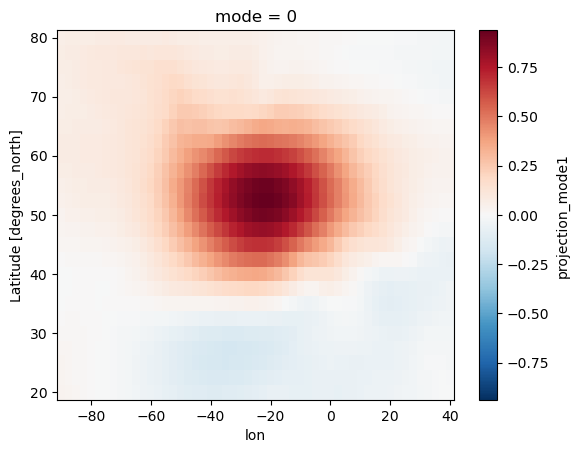

In [70]:
test = all_projections['hist-aer']['HadGEM3-GC31-LL']
print(test)

test['projection_mode1'].plot()

In [16]:
historical = ExperimentCalculations(Path("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/"), Path("/gws/nopw/j04/extant/users/slbennie/"))
historical.set_time_bounds(1850, 2014)
historical.set_domain(lat_bounds=(20,80), lon_bounds=(-90,40))
historical.set_season([12,1,2])

linear_trend = historical.projection_all_models(
    varname='psl',
    max_modes=2
)



#historical_ens_mean = historical.calc_ensemble_mean_all_models('psl', Path("/gws/nopw/j04/extant/users/slbennie/ens_mean_spat/psl/historical/"))

# Compute anomalies for all ensemble members and models
#anomaly_results = historical.calc_anomalies_all_models(
#    varname="psl",
#    output_dir=Path("/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/")
#)

#print(anomaly_results['CanESM5']['r10i1p1f1'].values)

#compute the EOF for all models

#HadGEM3 = historical.models['HadGEM3-GC31-LL']
#EOF = historical.calc_EOF_concat_all_models(
#    output_dir = Path('/gws/nopw/j04/extant/users/slbennie/EOF/'),
#                    varname='psl',
#                    max_modes=2
#)

Model name set to ACCESS-ESM1-5
Model name set to CMCC-CM2-SR5
Model name set to CNRM-CM6-1
Model name set to CanESM5
Model name set to FGOALS-g3
Model name set to GISS-E2-1-G
Model name set to HadGEM3-GC31-LL
Model name set to IPSL-CM6A-LR
Model name set to MIROC6
Model name set to MPI-ESM1-2-LR
Model name set to NorESM2-LM
loaded in 11 models for experiment 'historical'
<class 'numpy.datetime64'>
(datetime.datetime(1850, 1, 16, 0, 0), datetime.datetime(2014, 12, 16, 0, 0), 165)
<class 'cftime._cftime.DatetimeNoLeap'>
(cftime.DatetimeNoLeap(1850, 1, 16, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2014, 12, 16, 0, 0, 0, 0, has_year_zero=True), 165)
<class 'numpy.datetime64'>
(datetime.datetime(1850, 1, 16, 0, 0), datetime.datetime(2014, 12, 16, 0, 0), 165)
<class 'cftime._cftime.DatetimeNoLeap'>
(cftime.DatetimeNoLeap(1850, 1, 16, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2014, 12, 16, 0, 0, 0, 0, has_year_zero=True), 165)
<class 'cftime._cftime.DatetimeNoLeap'>

In [56]:
print(anomaly_results['CanESM5']['r10i1p1f1'])

<xarray.DataArray 'psl' (year: 165, lat: 25, lon: 53)> Size: 2MB
[218625 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 200B 20.0 22.5 25.0 27.5 30.0 ... 72.5 75.0 77.5 80.0
  * lon      (lon) float64 424B -90.0 -87.5 -85.0 -82.5 ... 32.5 35.0 37.5 40.0
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
    season   <U3 12B ...


In [16]:
model = ModelCalculations(Path("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/HadGEM3-GC31-LL/"), 'historical')
model.set_time_bounds(1850, 2014)
#model.set_season('DJF')
output_dir = "/gws/nopw/j04/extant/users/slbennie/"
seas_mean_DJF = model.calc_seasonal_mean_per_model(output_dir, 'DJF', 'psl')
#ens_mean = model.calc_ensemble_mean(Path("/gws/nopw/j04/extant/users/slbennie/ens_mean_spat/psl/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_spatial_DJF_EM_1850-2015.nc"), 'psl')
#ens_mean

Model name set to HadGEM3-GC31-LL


AttributeError: 'str' object has no attribute 'name'

In [68]:
model = ModelCalculations(Path("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/HadGEM3-GC31-LL/"))

model.set_time_bounds(1850, 2014)

member1 = next(iter(model.members.values()))

#so model.members is my dictionary of ensemble members, keys are member_ids values are EnsembleMemberCalculations objects
#"r1i1p1f1": <EnsembleMemberCalculations object>, ...
#the .values() returns all the values
#iter() lets you iterate throught the objects one by one
#next() grabs the firt item.

#EQUIVALENT
#first_key = list(model.members.keys())[0]
#member1 = model.members[first_key]

print(model.time_bounds)
print(member1.get_calendar_type())  # e.g., 'noleap'
print(member1.get_time_bounds())    # (start, end) as cftime objects

print(member1.select_data('psl'))

ens_mean = model.calc_ensemble_mean(Path("/gws/nopw/j04/extant/users/slbennie/ens_mean_spat/psl/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_spatial_DJF_EM_1850-2015.nc"), 'psl')


(cftime.Datetime360Day(1850, 1, 16, 0, 0, 0, 0, has_year_zero=True), cftime.Datetime360Day(2014, 12, 16, 0, 0, 0, 0, has_year_zero=True))
(cftime.Datetime360Day(1850, 1, 16, 0, 0, 0, 0, has_year_zero=True), cftime.Datetime360Day(2014, 12, 16, 0, 0, 0, 0, has_year_zero=True))
360_day
<xarray.DataArray 'psl' (time: 1980, lat: 71, lon: 144)> Size: 162MB
[20243520 values with dtype=float64]
Coordinates:
  * time     (time) object 16kB 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lat      (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon      (lon) float64 1kB -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    comment:        Sea Level Pressure
    units:          Pa
    original_name:  mo: (stash: m01s16i222, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
Loading the exisiting file for the spatial ensemble mean from: /gw

In [24]:
#idea is to create objects for all the ensembles within the folder
#within the class there will be a method to extract the member_id from the filename


folder = Path('/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/HadGEM3-GC31-LL/')

#collecting all the ensemble members in this folder - slightly tricky in that depends on this folder not really being altered?
ensemble_members = [
    EnsembleMemberCalculations(file)
    for file in folder.glob("*.nc")
]

print([member.member_id for member in ensemble_members])

#loading in the data
ds = ensemble_members[0].load_data()
ensemble_members[0].get_time_bounds('1850', '2014')

['r11i1p1f3', 'r12i1p1f3', 'r13i1p1f3', 'r14i1p1f3', 'r15i1p1f3', 'r16i1p1f3', 'r17i1p1f3', 'r18i1p1f3', 'r19i1p1f3', 'r1i1p1f3', 'r20i1p1f3', 'r21i1p1f3', 'r22i1p1f3', 'r23i1p1f3', 'r24i1p1f3', 'r25i1p1f3', 'r26i1p1f3', 'r27i1p1f3', 'r28i1p1f3', 'r29i1p1f3', 'r2i1p1f3', 'r30i1p1f3', 'r31i1p1f3', 'r32i1p1f3', 'r33i1p1f3', 'r34i1p1f3', 'r35i1p1f3', 'r36i1p1f3', 'r37i1p1f3', 'r38i1p1f3', 'r39i1p1f3', 'r3i1p1f3', 'r40i1p1f3', 'r41i1p1f3', 'r42i1p1f3', 'r43i1p1f3', 'r44i1p1f3', 'r45i1p1f3', 'r46i1p1f3', 'r47i1p1f3', 'r48i1p1f3', 'r49i1p1f3', 'r4i1p1f3', 'r50i1p1f3', 'r51i1p1f3', 'r52i1p1f3', 'r53i1p1f3', 'r54i1p1f3', 'r55i1p1f3', 'r56i1p1f3', 'r57i1p1f3', 'r58i1p1f3', 'r59i1p1f3', 'r5i1p1f3', 'r60i1p1f3']
1850


In [8]:
member1 = EnsembleMemberCalculations(
    member_id='1',
    data_path = Path('/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r1i1p1f3_interp.nc')
)

ds = member1.load_data()

print(member1.member_id)
print(ds)


1
<xarray.Dataset> Size: 169MB
Dimensions:    (time: 1980, bnds: 2, lat: 71, lon: 144)
Coordinates:
  * time       (time) object 16kB 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lat        (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5
  * lon        (lon) float64 1kB -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 32kB ...
    lat_bnds   (time, lat, bnds) float64 2MB ...
    lon_bnds   (time, lon, bnds) float64 5MB ...
    psl        (time, lat, lon) float64 162MB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-06-19T12:06:35Z
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    variable_id:            psl
    variant_label:          r1i1p1f3
    li

In [ ]:
class EnsembleMemberProcessing:
    def __init__(self, member_id: str, data_path:Path):
        #use self. to access the attributes
        self.member_id = member_id
        self.datat_path = Path(data_path)
        self.data = None
        self.eofs = None

    def load_data(self):
        #loading the LESFMIP data in for each ensemble member
        #each object has a path attribute
        self.data = xr.open_dataset(self.data_path)
        return self.data

    def calculate_EOF(self, domain='North Atlantic'):
        #will add in code to calculate the EOFs
        #for now just a test
        #domain would be passed through.
        print(f"calculating the EOF for the domain: {domain} for {self.member_id")
        #self.eofs = xr.Dataset()
        #EOF calculation
        #return self.eofs

    def save_eofs(self, path: Path):
        if self.eofs is not None:
            path.parent.mkdir(parents=True, exist_ok=True)
            self.eofs.to_netcdf(path)
            print(f"saved EOFs for {self.member_id} to {path}")

class EnsembleMemberProcessed:
    def __init__(self, member_id: str, eofs: xr.Dataset):
        self.member_id = member_id
        self.eofs = eofs

    @classmethod
    def from_file(cls, member_id: str, eofs_path: Path):
        eofs = xr.open_dataset(eofs_path)
        print(f"Loaded EOFs for {member_id} from {eofs_path}")
        return cls(member_id=member_id, eofs=eofs)


class ModelCalculations:
    def __init__(self, model_name: str, ensemble_members_processing: dict = None, ensemble_members_processed: dict = None, eof_mode='NAO'):
        self.model_name = model_name
        self.eof_mode = eof_mode

        #Making sue the code doesn't calculate new and load in old.
        if ensemble_members_processing is not None and ensemble_members_processed is not None:
            raise ValueError("Provide either ensemble_members_processing OR ensemble_members_processed - NOT both!")

        if ensemble_members_processing is not None:
            self.mode = 'raw'
            self.ensemble_members_processing = ensemble_members_processing
            #so now it calculates the things I need, well hopefully....
            #mid is just ensemble member id
            #computing the EOFs
            #results in a dictionary mapping the member ID to the processed EOFs
            self.ensemble_members_processed = {}

        elif ensemble_members_processed is not None:
            #basically just stores the data given
            self.mode = 'processed'
            self.ensemble_members_processed = ensemble_members_processed
            self.ensemble_members_processing = None
        else:
            raise ValueError('Need at least either ensemble_members_processing OR ensemble_members_processed')


    # ------------------
    # For raw members: calculate EOFs and optionally save
    # ------------------
    def calculate_raw_eofs(self, save_dir: Path = None):
        if self.mode != "raw":
            raise RuntimeError("This method is only valid for raw ensemble members.")
        for mid, member in self.ensemble_members_processing.items():
            #member.load_data()
            #eofs = member.calculate_eofs(self.eof_mode)
            #self.ensemble_members_processing[mid] = EnsembleMemberProcessed(mid, eofs)
            #if save_dir is not None:
            #    save_path = save_dir / f"{mid}_{self.eof_mode}_eofs.nc"
            #    member.save_eofs(save_path)
        print("All raw EOFs calculated and processed members created.")

    # ------------------
    # For processed members: load EOFs from .nc
    # ------------------
    @classmethod
    def from_processed_files(cls, model_name: str, file_paths: dict, eof_mode="NAO"):
        processed_members = {}
        for mid, path in file_paths.items():
            processed_members[mid] = EnsembleMemberProcessed.from_file(mid, Path(path))
        return cls(model_name, processed_ensemble_members=processed_members, eof_mode=eof_mode)
        